# Statistical Mean Reversion

Mean reversion is a trading strategy positing that asset prices and returns tend to revert to their long-term mean or average level over time. Mathematically, such a continuous-time series is represented by an Ornstein-Uhlenbeck process, where the change in price series in the next period is proportional to the difference between the mean price and the current price. In contrast, a random walk, or Brownian motion, where current price movements are independent of historical data, lacks the "memory" of its previous states at any given moment in time. The mean-reverting characteristic of such time series can be leveraged to design and implement profitable trading strategies.

# Augmented Dickey-Fuller (ADF) Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a given time series is stationary or not. A stationary time series has properties that do not depend on the time at which the series is observed; specifically, its mean, variance, and autocorrelation structure remain constant over time. The ADF test is used to test for the presence of a unit root.

## Basic Model

The basic Dickey-Fuller test can be represented by the following autoregressive model:

$y_t = \rho y_{t-1} + \epsilon_t$

where:
- $y_t$ is the time series observation,
- $\epsilon_t$ is the white noise error term.

## Augmentation

To account for higher-order autoregressive processes and improve the test's robustness, the ADF test uses an augmented model that includes lagged differences of $y_t$:

$\Delta y_t = \alpha + \beta t + \rho y_{t-1} + \sum_{i=1}^p \phi_i \Delta y_{t-i} + \epsilon_t$

where:
- $\Delta y_t = y_t - y_{t-1}$ is the first difference of $y_t$,
- $\alpha$ is the constant term,
- $\beta t$ represents the trend term (optional),
- $\rho$ is the coefficient on the lagged level of the time series,
- $\phi_i$ are coefficients for the lagged differences,
- $p$ is the number of lagged differences included,
- $\epsilon_t$ is the error term.

## Hypotheses

- **Null Hypothesis (H0)**: $\rho = 0$. This implies that the time series has a unit root and is non-stationary.
- **Alternative Hypothesis (H1)**: $\rho < 0$. This implies that the time series is stationary.

## Test Statistic

The test statistic for the ADF test is derived from the estimated value of $\rho$. Specifically, we estimate the model and obtain the coefficient $\hat{\rho}$ on $y_{t-1}$. The test statistic is:

$\text{ADF Statistic} = \frac{\hat{\rho} - 1}{\text{SE}(\hat{\rho})}$

where $\text{SE}(\hat{\rho})$ is the standard error of the $\hat{\rho}$ estimate.

## Critical Values

The calculated ADF statistic is compared to critical values from the Dickey-Fuller distribution. These critical values vary depending on whether the model includes a constant, a trend, or neither.

## Decision Rule

- **If the ADF statistic is less than the critical value**: Reject the null hypothesis $H_0$, suggesting the time series is stationary.
- **If the ADF statistic is greater than the critical value**: Fail to reject the null hypothesis $H_0$, suggesting the time series is non-stationary.

In [36]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import yfinance as yf
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

In [37]:
ticker=["GOOG"]

# Fetch historical data for the ticker
data = yf.download(ticker, start='2020-01-01', end='2024-01-01',interval="1d")

# Select the 'Adj Close' price for the test
close_prices = data['Adj Close'].dropna()

# Perform the ADF test
adf_result = ts.adfuller(close_prices,1)

# Print the ADF test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

[*********************100%%**********************]  1 of 1 completed
ADF Statistic: -1.511345373321048
p-value: 0.5278916656917815
Critical Values:
   1%: -3.4368734638130847
   5%: -2.8644201518188126
   10%: -2.5683035273879358


# Hurst Exponent

The **Hurst exponent** ($H$) is a statistical measure used to determine the long-term memory of time series data. It helps identify whether a time series is **persistent**, **mean-reverting**, or exhibits **random walk behavior**. 


## Formula

The Hurst exponent is defined as:

$
E[R(n)/S(n)] = Cn^H
$

Where:
- $E[R(n)/S(n)]$ is the expected rescaled range (range of cumulative deviations divided by standard deviation) of the time series over $n$ periods.
- $C$ is a constant.
- $n$ is the time period.
- $H$ is the Hurst exponent, which lies in the range $0 \leq H \leq 1$.

## Interpretation

The value of the Hurst exponent indicates the nature of the time series:

- **$H = 0.5$**: The time series follows a random walk (i.e., no autocorrelation, purely stochastic process like Brownian motion).
- **$H < 0.5$**: The time series is **mean-reverting**. This suggests that if the time series has been increasing, it is likely to decrease in the future, and vice versa (negative autocorrelation).
- **$H > 0.5$**: The time series is **persistent**. This implies that trends in the data are likely to continue in the same direction (positive autocorrelation).



In [38]:
def hurst(ts):

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Assuming you have run the above code to obtain 'data'!
print("Hurst",ticker,": %s" % hurst(data['Adj Close'].values))

Hurst ['GOOG'] : 0.47221629710502977


In [47]:
from arch.unitroot import VarianceRatio

vr = VarianceRatio(data['Adj Close'], 5)
print(vr.summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                 -1.315
P-value                         0.189
Lags                                5
-------------------------------------

Computed with overlapping blocks (de-biased)


In [39]:
def calculate_half_life(series):
    # Calculate the lagged series
    series_lag = series.shift(1)
    
    # Calculate the change in the series
    delta_series = series - series_lag
    
    # Remove missing values
    series_lag = series_lag[1:]
    delta_series = delta_series[1:]
    
    # Add a constant term to the lagged series
    series_lag_constant = sm.add_constant(series_lag)
    
    # Fit the AR(1) model
    model = sm.OLS(delta_series, series_lag_constant)
    results = model.fit()
    
    # Get the AR(1) coefficient
    theta = results.params.iloc[1]  # Use iloc to avoid the warning
    
    # Calculate the half-life
    half_life = -np.log(2) / theta
    
    return half_life

# Calculate half-life
halflife = calculate_half_life(close_prices)
print("Half-Life of Mean Reversion:", halflife)

Half-Life of Mean Reversion: 170.8613612114887


In [40]:
def calculate_half_life(series):
    # Calculate the lagged series
    series_lag = series.shift(1)
    
    # Calculate the change in the series
    delta_series = series - series_lag
    
    # Remove missing values
    series_lag = series_lag[1:]
    delta_series = delta_series[1:]
    
    # Add a constant term to the lagged series
    series_lag_constant = sm.add_constant(series_lag)
    
    # Fit the AR(1) model
    model = sm.OLS(delta_series, series_lag_constant)
    results = model.fit()
    
    # Get the AR(1) coefficient
    theta = results.params.iloc[1]  # Use iloc to avoid the warning
    
    # Calculate the half-life
    half_life = -np.log(2) / theta
    
    return half_life

# Calculate half-life
halflife = calculate_half_life(close_prices)
print("Half-Life of Mean Reversion:", halflife)

Half-Life of Mean Reversion: 170.8613612114887


<Axes: xlabel='Date'>

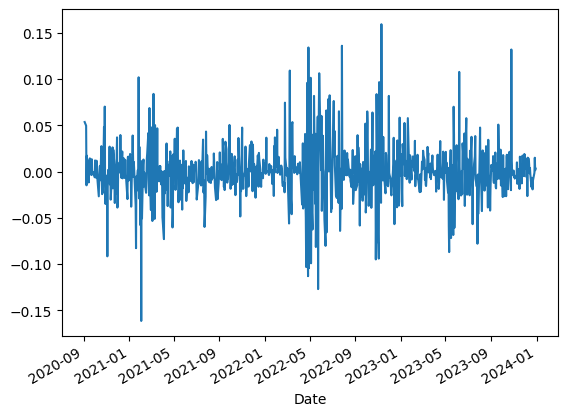

In [41]:
# Function to calculate the moving average
def moving_avg(close_prices, lookback):
    return close_prices.rolling(window=lookback).mean()

# Function to calculate the moving standard deviation
def moving_std(close_prices, lookback):
    return close_prices.rolling(window=lookback).std()

# Function to lag the series by 1 (shift by 1)
def lag(series, periods=1):
    return series.shift(periods)

# Assuming 'y' is a pandas Series and 'halflife' is defined
lookback = round(halflife)  # Setting lookback to halflife

# Calculate market value
mktVal = -(close_prices - moving_avg(close_prices, lookback)) / moving_std(close_prices, lookback)

# Calculate PnL
pnl = lag(mktVal, 1) * (close_prices - lag(close_prices, 1)) / lag(close_prices, 1)
pnl.dropna().plot()
